In [12]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import os
from numba import cuda 
plt.style.use("science.mplstyle")

from helpers.composite_helpers import *

In [13]:
sim_color = "#990000"
trans_color = "#674ea7"
dat_color = "#1c4587"

dpi = 800

feta_dir = "/global/home/users/rrmastandrea/FETA/"


# Toy model plots

In [14]:
n_features = 1
dataset_config_string = f"triangle_npoints100000_nfeatures2/"

exp_dir = os.path.join(feta_dir, dataset_config_string)
data_dir = os.path.join(exp_dir, "data")


bands_dict = {
              "sb1": [0, .34],
              "sr" : [.34, .66],
              "sb2": [.66, 1],
             }


bands_to_plot = list(bands_dict.keys())

binning_scheme = np.linspace(-3.5, 3.5, 50)

In [15]:
# calculate band rocs

In [16]:
seed = 1

num_layers_BD_sim = 2
num_hidden_features_BD_sim = 16

loc_id_BD_sim = f"BD_sim_Masked_PRQ_AR_{num_layers_BD_sim}layers_{num_hidden_features_BD_sim}hidden_seed{seed}"
BD_sim_training_dir = os.path.join(exp_dir, f"saved_models_{loc_id_BD_sim}/")

num_layers_s2d = 2
num_hidden_features_s2d = 16


loc_id_s2d = f"s2d_Masked_PRQ_AR_{num_layers_s2d}layers_{num_hidden_features_s2d}hidden_seed{seed}"
s2d_training_dir = os.path.join(BD_sim_training_dir, f"saved_models_{loc_id_s2d}/")
s2d_samples_dir = os.path.join(s2d_training_dir, f"npy_samples/")
    
sim_samples = {}
transformed_sim_samples = {}
dat_samples = {}

for band in list(bands_dict.keys()):
    # sim
    sim_samples[band] = np.load(os.path.join(s2d_samples_dir, f"{band}_SIM.npy"))
    # trans sim
    transformed_sim_samples[band] = np.load(os.path.join(s2d_samples_dir, f"{band}_transSIM.npy"))
    # dat
    dat_samples[band] = np.load(os.path.join(s2d_samples_dir, f"{band}_DAT.npy"))

In [17]:
# These are the results from running SALAD. The array must be hard-coded like this...apologies!

salad_hist = np.array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.42415626e-15,
       1.61387742e-13, 1.26647444e-12, 9.25745197e-12, 5.91036194e-11,
       3.66833154e-10, 2.30308300e-09, 1.38088851e-08, 8.84612503e-08,
       5.39145832e-07, 3.21976018e-06, 1.94699981e-05, 1.13318618e-04,
       6.71859998e-04, 8.77587797e-03, 6.83664931e-02, 1.43995251e-01,
       2.20881829e-01, 2.84968063e-01, 3.61674345e-01, 4.35752084e-01,
       5.06354864e-01, 5.67855070e-01, 6.40081440e-01, 7.18702344e-01,
       8.29428051e-01, 9.10408791e-01, 9.33213642e-01, 3.68733344e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

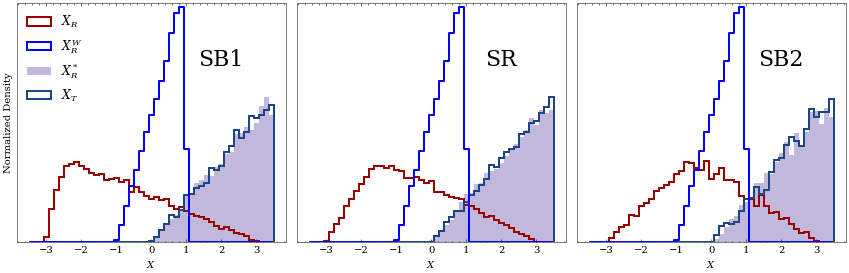

In [18]:

n_plot = -1

alpha = 0.4

w = 2

fig, ax = plt.subplots(1, 3, figsize = (12, 4))#, gridspec_kw={'height_ratios': [2, 1]})

band_labels = ["SB1", "SR", "SB2"]

bin_centers = 0.5*(binning_scheme[1:] + binning_scheme[:-1])


for i, band in enumerate(bands_to_plot):
    


    # Plots hists
    ax[i].hist(sim_samples[band][:n_plot,0], bins = binning_scheme, label = "$X_R$", histtype = "step", color = sim_color, density = True, linewidth = w)
    
    ax[i].hist(dat_samples[band][:n_plot,0], bins = binning_scheme, label = "$X^W_R$", histtype = "step", color = "blue", density = True, linewidth = w)            
    ax[i].step(bin_centers, salad_hist, color = "blue", linewidth = w, where = "mid")
    
    ax[i].hist(transformed_sim_samples[band][:n_plot,0], bins = binning_scheme, label = "$X^*_R$", histtype = "bar", alpha = alpha, color = trans_color, density = True)

    ax[i].hist(dat_samples[band][:n_plot,0], bins = binning_scheme, label = "$X_T$", histtype = "step", color = dat_color, density = True, linewidth = w)

    
    ax[i].set_xlabel("$X$")

    ax[i].set_yticks([])
    ax[i].set_ylim((0, .95))

    """
    # Plot ratios
    sim_hist, _ = np.histogram(sim_samples[band][:n_plot,0], bins = binning_scheme, density = True)
    trans_sim_hist, _ = np.histogram(transformed_sim_samples[band][:n_plot,0], bins = binning_scheme, density = True)
    dat_hist, _ = np.histogram(dat_samples[band][:n_plot,0], bins = binning_scheme, density = True)

    sim_ratio = np.divide(sim_hist, dat_hist, out=np.zeros_like(sim_hist), where=dat_hist!=0)
    trans_sim_ratio = np.divide(trans_sim_hist, dat_hist, out=np.zeros_like(trans_sim_hist), where=dat_hist!=0)
    salad_ratio = np.divide(salad_hist, dat_hist, out=np.zeros_like(salad_hist), where=dat_hist!=0)


    width = bin_centers[1] - bin_centers[0]

    ax[1, i].step(bin_centers, sim_ratio, color = sim_color, where = "mid", label = "SIM/DAT", linewidth = w)
    ax[1, i].step(bin_centers, salad_ratio, color = "blue", where = "mid", label = "(reweighted SIM)/DAT", linewidth = w)

    ax[1, i].fill_between(bin_centers, trans_sim_ratio, step="mid", alpha = alpha, label = "(trans SIM)/DAT", color = trans_color)
    ax[1, i].plot(bin_centers, np.full(bin_centers.shape, 1), color = "black")
    ax[1, 0].set_ylabel("Ratio to DAT")
    ax[1, i].set_ylim((0, 2))
    """
        
    ax[0].set_ylabel("Normalized Density")  

    
    ax[i].text(2, .7, band_labels[i], fontsize = 22, ha = "center")
    
    ax[0].legend(fontsize = 12, loc = "upper left")
    

plt.tight_layout()
fig.savefig(f"paper_plots/toy_results.pdf", dpi = dpi)
fig.show()


    
    


   



# LHC plots

In [19]:
n_features = 5
dataset_config_string = f"LHCO_0sig_f/"

exp_dir = os.path.join(feta_dir, dataset_config_string)
data_dir = os.path.join(exp_dir, "data")

# dataset generation parameters
context_endpoints = (2500, 4500)

bands_dict = {"sb1": [2900, 3300],
                  "sr" : [3300, 3700],
                  "sb2": [3700, 4100],
            }

binning_scheme = np.linspace(-3., 3., 50)

n_features = 5

feature_labels = ["$m_{J_1}$ [GeV]", "$\Delta m_{JJ}$ [GeV]", "$\\tau^{21}_{J_1}$", "$\\tau^{21}_{J_2}$", "$\Delta R_{JJ}$", "$m_{JJ}$ [GeV]"]


### Pretty plots for NIPS poster

In [20]:
# get the data

df_sim = get_lhco(sim_type = "herwig")
data_sim = select_lhco_features(df_sim, feature_type = 0).to_numpy()

df_dat = get_lhco(sim_type = "pythia")
data_dat = select_lhco_features(df_dat, feature_type = 0).to_numpy()

df_signal = get_lhco(sim_type = "pythia", sm = "signal")
data_signal = select_lhco_features(df_signal, feature_type = 0).to_numpy()


events_anomalydetection_herwig_features.h5
events_anomalydetection_v2.features.h5
events_anomalydetection_v2.features.h5


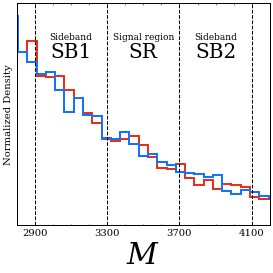

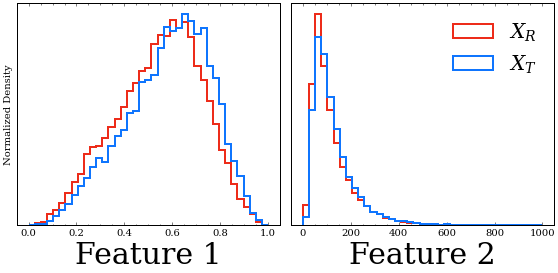

In [21]:
# features plots

alpha = 0.5
n_plot = 10000
bins = 40
w = 2


import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1 #set the value globally


n_features = 6
    

"""fig, ax = plt.subplots(1, n_features, figsize = (4*n_features, 5))

for i in range(n_features):
    ax[i].hist(data_sim[:n_plot,i], bins = bins, density = True, label = "SIM", histtype = "step", color = sim_color, linewidth = w)
    ax[i].hist(data_dat[:n_plot,i], bins = bins, density = True, label = "DAT", histtype = "step", color = dat_color, linewidth = w)
    ax[i].hist(data_signal[:n_plot,i], bins = bins, density = True, label = "Signal", histtype = "step", color = "green", linewidth = w)

    ax[i].set_xlabel(feature_labels[i], fontsize = 30)
    ax[i].set_yticks([])
    
ax[0].set_ylabel("Normalized Density")  
ax[0].legend(fontsize = 20)  
plt.tight_layout()
fig.savefig("paper_plots/features_w_sig.png", dpi = dpi)
fig.show()

    """




plt.figure(figsize = (4, 4))

bins = np.linspace(2500, 4500, 40)

plt.hist(data_sim[:n_plot,5], bins = bins, density = True, label = "$X_R$", histtype = "step", color = "#ED2C1A", linewidth = w)
plt.hist(data_dat[:n_plot,5], bins = bins, density = True, label = "$X_T$", histtype = "step", color = "#0F75FE", linewidth = w)
plt.axvline(2900, color = "black", linestyle = "dashed")
plt.axvline(3300, color = "black", linestyle = "dashed")
plt.axvline(3700, color = "black", linestyle = "dashed")
plt.axvline(4100, color = "black", linestyle = "dashed")

plt.text(3100, .001, "Sideband", horizontalalignment='center', fontsize = 9)
plt.text(3500, .001, "Signal region", horizontalalignment='center', fontsize = 9)
plt.text(3900, .001, "Sideband", horizontalalignment='center', fontsize = 9)

plt.text(3100, .0009, "SB1", horizontalalignment='center', fontsize = 20)
plt.text(3500, .0009, "SR", horizontalalignment='center', fontsize = 20)
plt.text(3900, .0009, "SB2", horizontalalignment='center', fontsize = 20)


plt.xlabel("$M$", fontsize = 30)
plt.xlim(2800, 4200)
plt.yticks([])
plt.xticks([2900, 3300, 3700, 4100])

plt.ylabel("Normalized Density")  
#plt.legend(fontsize = 20)  
plt.tight_layout()
plt.savefig("paper_plots/M.png", dpi = dpi)
plt.show()


fig, ax = plt.subplots(1, 2, figsize = (8, 4))

bins = np.linspace(0, 1, 40)
ax[0].hist(data_sim[:n_plot,2], bins = bins, density = True, label = "$X_R$", histtype = "step", color = "#ED2C1A", linewidth = w)
ax[0].hist(data_dat[:n_plot,2], bins = bins, density = True, label = "$X_T$", histtype = "step", color = "#0F75FE", linewidth = w)
ax[0].set_xlabel("Feature 1", fontsize = 30)
ax[0].set_yticks([])

bins = np.linspace(0, 1000, 40)
ax[1].hist(data_sim[:n_plot,0], bins = bins, density = True, label = "$X_R$", histtype = "step", color = "#ED2C1A", linewidth = w)
ax[1].hist(data_dat[:n_plot,0], bins = bins, density = True, label = "$X_T$", histtype = "step", color = "#0F75FE", linewidth = w)
ax[1].set_xlabel("Feature 2", fontsize = 30)
ax[1].set_yticks([])

ax[0].set_ylabel("Normalized Density")  
ax[1].legend(fontsize = 20)  
plt.tight_layout()
fig.savefig("paper_plots/features_nips.png", dpi = dpi)
fig.show()

   



## Results (0 sig)

In [23]:
seed = 1

num_layers_BD_sim = 1
num_blocks = 15
num_hidden_features_BD_sim = 128


loc_id_BD_sim = f"BD_sim_Masked_PRQ_AR_{num_layers_BD_sim}layers_{num_hidden_features_BD_sim}hidden_{num_blocks}blocks_{seed}seed"
BD_sim_training_dir = os.path.join(exp_dir, f"saved_models_{loc_id_BD_sim}/")

num_layers_s2d = 2
num_nodes_s2d = 16

loc_id_s2d = f"PRQ_Coupling_{num_layers_s2d}layers_{num_nodes_s2d}nodes_{seed}seed"
s2d_training_dir = os.path.join(BD_sim_training_dir, f"saved_models_{loc_id_s2d}/")
s2d_samples_dir = os.path.join(s2d_training_dir, f"npy_samples/")


    
sim_samples = {}
transformed_sim_samples = {}
dat_samples = {}

for band in list(bands_dict.keys()):
    # sim
    sim_samples[band] = np.load(os.path.join(s2d_samples_dir, f"{band}_SIM.npy"))
    # trans sim
    transformed_sim_samples[band] = np.load(os.path.join(s2d_samples_dir, f"{band}_transSIM.npy"))
    # dat
    dat_samples[band] = np.load(os.path.join(s2d_samples_dir, f"{band}_DAT.npy"))
    
    
bands_to_plot = list(bands_dict.keys())



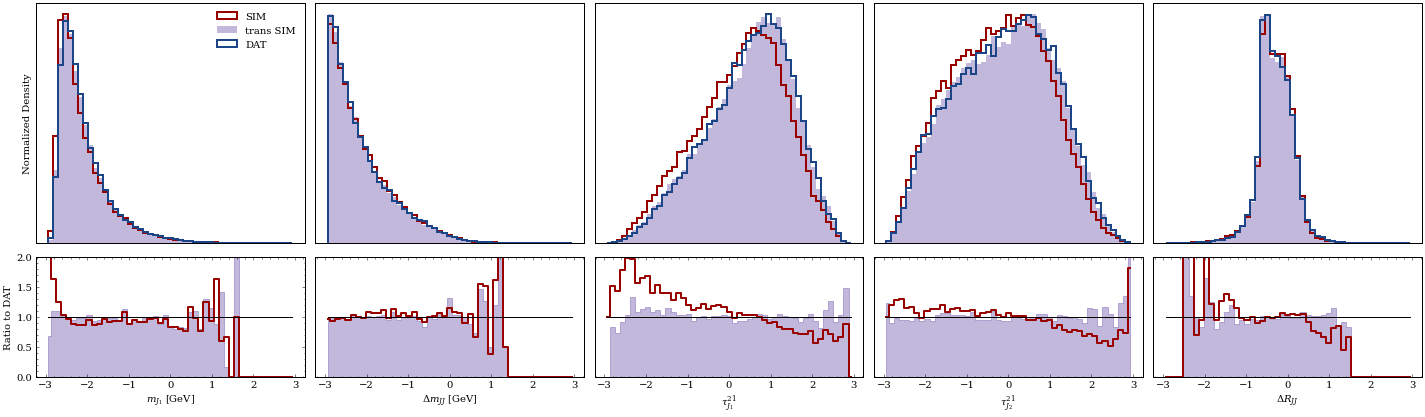

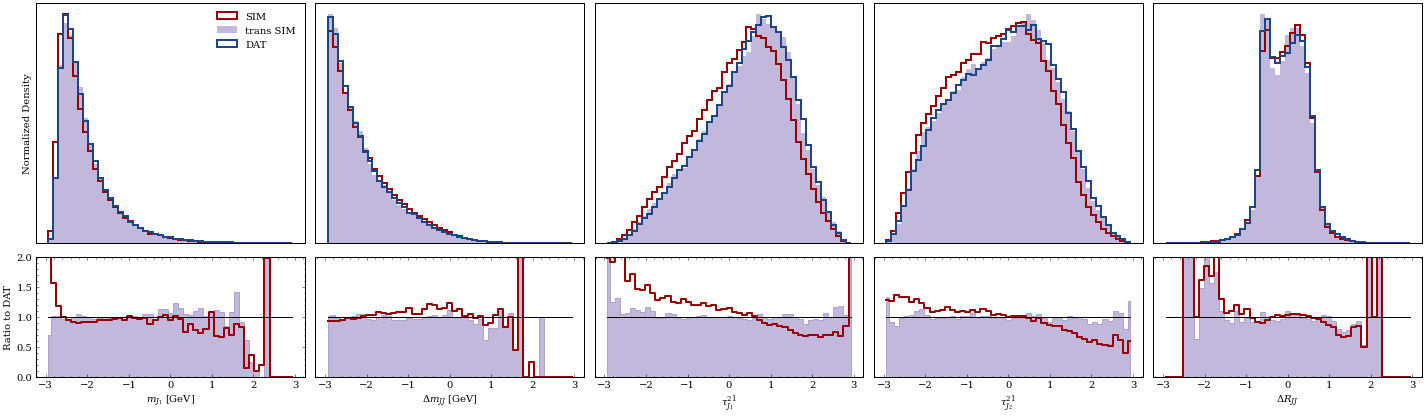

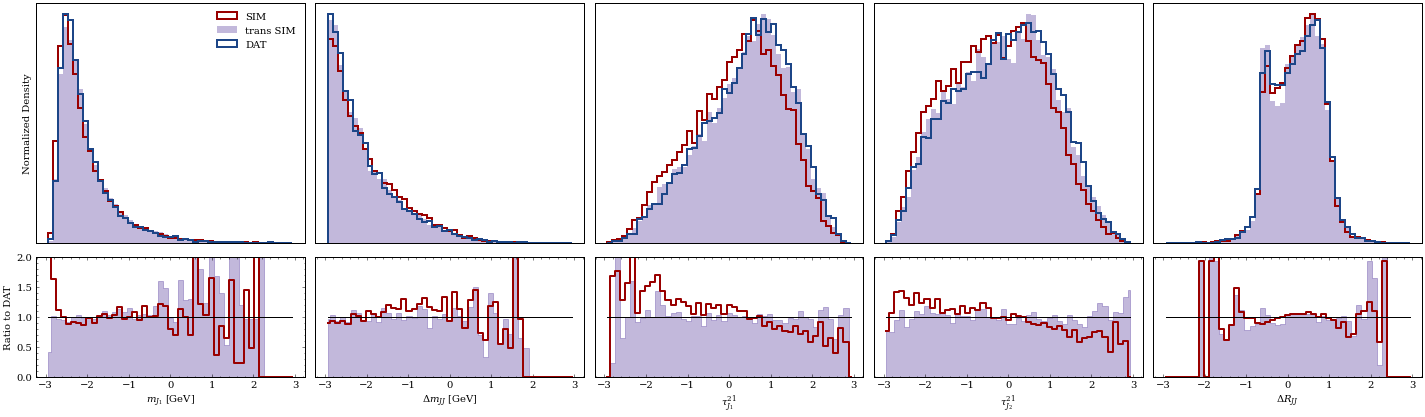

In [24]:

n_plot = -1

alpha = 0.4
n_features = 5

for band in bands_to_plot:
    

    fig, ax = plt.subplots(2, n_features, figsize = (4*(n_features), 6), gridspec_kw={'height_ratios': [2, 1]})
    for i in range(n_features):

        # Plots hists
        ax[0, i].hist(sim_samples[band][:n_plot,i], bins = binning_scheme, label = "SIM", histtype = "step", color = sim_color, density = True, linewidth = w)
        ax[0, i].hist(transformed_sim_samples[band][:n_plot,i], bins = binning_scheme, label = "trans SIM", histtype = "bar", alpha = alpha, color = trans_color, density = True)
        ax[0, i].hist(dat_samples[band][:n_plot,i], bins = binning_scheme, label = "DAT", histtype = "step", color = dat_color, density = True, linewidth = w)
        
        ax[0, i].set_xticks([])
        ax[0, i].set_yticks([])

        # Plot ratios
        sim_hist, _ = np.histogram(sim_samples[band][:n_plot,i], bins = binning_scheme, density = True)
        trans_sim_hist, _ = np.histogram(transformed_sim_samples[band][:n_plot,i], bins = binning_scheme, density = True)
        dat_hist, _ = np.histogram(dat_samples[band][:n_plot,i], bins = binning_scheme, density = True)

        sim_ratio = np.divide(sim_hist, dat_hist, out=np.zeros_like(sim_hist), where=dat_hist!=0)
        trans_sim_ratio = np.divide(trans_sim_hist, dat_hist, out=np.zeros_like(trans_sim_hist), where=dat_hist!=0)

        bin_centers = 0.5*(binning_scheme[1:] + binning_scheme[:-1])
        width = bin_centers[1] - bin_centers[0]

        ax[1, i].step(bin_centers, sim_ratio, color = sim_color, where = "mid", label = "SIM/DAT", linewidth = w)
        ax[1, i].fill_between(bin_centers, trans_sim_ratio, step="mid", alpha = alpha, label = "(trans SIM)/DAT", color = trans_color)
        ax[1, i].plot(bin_centers, np.full(bin_centers.shape, 1), color = "black")
        ax[1, i].set_xlabel(feature_labels[i])
        ax[1, i].set_ylim([0,2])
        if i != 0:
            ax[1, i].set_yticks([])
        
    ax[0, 0].set_ylabel("Normalized Density")  
    ax[1, 0].set_ylabel("Ratio to DAT")
    
    
    
    ax[0, 0].legend()

    plt.tight_layout()
    fig.savefig(f"paper_plots/results_{band}.pdf", dpi = dpi)
    fig.show()
    



### Pretty schematics for the paper / talks

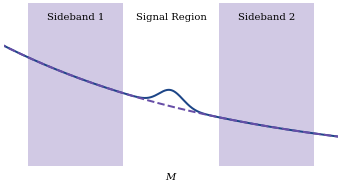

In [29]:
def exp(x, alpha, N):
    return N*np.exp(-alpha*x)

def signal(x, alpha, N, mu, sigma, M):
    return N*np.exp(-alpha*x) + M*np.exp(-0.5*((x-mu)/sigma)**2)

min_range = 0
max_range = 1

n_bkg = 1000
n_sig = 100


w = 2
alpha = 0.3

fig = plt.figure(figsize = (6, 3))


x = np.linspace(0, 1, 1000)


# signal
plt.plot(x, signal(x, 2, n_bkg, .5, .025, n_sig), color = dat_color, linewidth = 2)

# background
plt.plot(x, signal(x, 2, n_bkg, .5, .025, 0), color = trans_color, linewidth = 2, linestyle = "dashed")


# SB1
plt.fill_between([.2, .4], [0, 0], [1000, 1000], color = trans_color, alpha = alpha, linewidth = 0)
plt.text(.3, 900, "Sideband 1", color = "black", ha = "center")
# SB2
plt.fill_between([.6, .8], [0, 0], [1000, 1000], color = trans_color, alpha = alpha, linewidth = 0)
plt.text(.7, 900, "Sideband 2", color = "black", ha = "center")

# SR
plt.text(.5, 900 , "Signal Region", color = "black", ha = "center")


plt.xlabel("$M$")
plt.xlim(0.15, 0.85)
plt.ylim(0, 1000)
plt.xticks([])
plt.yticks([])
ax = plt.gca()
plt.setp(ax.spines.values(), visible=False)

fig.savefig("paper_plots/schematic_1.png", dpi = dpi)





plt.show()

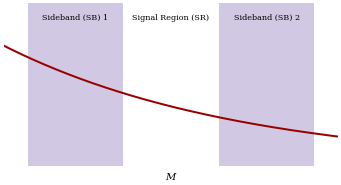

In [30]:
fig = plt.figure(figsize = (6, 3))

# background
#plt.plot(x, exp(x, 2, n_bkg))

# signal
plt.plot(x, signal(x, 2, n_bkg, .5, .025, 0), color = sim_color, linewidth = 2)

# SB1
plt.fill_between([.2, .4], [0, 0], [1000, 1000], color = trans_color, alpha = alpha, linewidth = 0)
plt.text(.3, 900, "Sideband (SB) 1", color = "black", ha = "center", fontsize = 8)
# SB2
plt.fill_between([.6, .8], [0, 0], [1000, 1000], color = trans_color, alpha = alpha, linewidth = 0)
plt.text(.7, 900, "Sideband (SB) 2", color = "black", ha = "center", fontsize = 8)

# SR
plt.text(.5, 900 , "Signal Region (SR)", color = "black", ha = "center", fontsize = 8)


plt.xlabel("$M$")
plt.xlim(0.15, 0.85)
plt.ylim(0, 1000)
plt.xticks([])
plt.yticks([])
ax = plt.gca()
plt.setp(ax.spines.values(), visible=False)

fig.savefig("paper_plots/schematic_2.png", dpi = dpi)


plt.show()

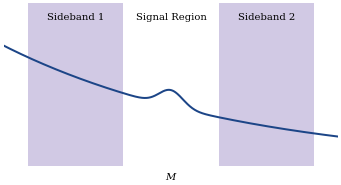

In [31]:

fig = plt.figure(figsize = (6, 3))



# signal
plt.plot(x, signal(x, 2, n_bkg, .5, .025, n_sig), color = dat_color, linewidth = 2)

# background


# SB1
plt.fill_between([.2, .4], [0, 0], [1000, 1000], color = trans_color, alpha = alpha, linewidth = 0)
plt.text(.3, 900, "Sideband 1", color = "black", ha = "center")
# SB2
plt.fill_between([.6, .8], [0, 0], [1000, 1000], color = trans_color, alpha = alpha, linewidth = 0)
plt.text(.7, 900, "Sideband 2", color = "black", ha = "center")

# SR
plt.text(.5, 900 , "Signal Region", color = "black", ha = "center")


plt.xlabel("$M$")
plt.xlim(0.15, 0.85)
plt.ylim(0, 1000)
plt.xticks([])
plt.yticks([])
ax = plt.gca()
plt.setp(ax.spines.values(), visible=False)
fig.savefig("paper_plots/schematic_3.png", dpi = dpi)


plt.show()

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


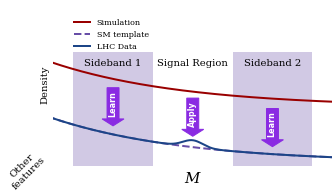

In [32]:

# big schematic



fig = plt.figure(figsize = (5, 3))

y_min = 200
y_max = 600

# sim
plt.plot(x, signal(x, 3, n_bkg, .5, .025, 0)+y_max, color = sim_color, linewidth = 2, label = "Simulation")

# template
plt.plot(x, signal(x, 3, n_bkg, .5, .025, 0) - y_min, color = trans_color, linewidth = 2, linestyle = "dashed", label = "SM template")

# data
plt.plot(x, signal(x, 3, n_bkg, .5, .025, n_sig) - y_min, color = dat_color, linewidth = 2, label = "LHC Data")




# SB1
plt.fill_between([.2, .4], [-y_min-50, -y_min-50], [y_max+800, y_max+800], color = trans_color, alpha = alpha, linewidth = 0)
plt.text(.3, 1200, "Sideband 1", color = "black", ha = "center")
# SB2
plt.fill_between([.6, .8], [-y_min-50, -y_min-50], [y_max+800, y_max+800], color = trans_color, alpha = alpha, linewidth = 0)
plt.text(.7, 1200, "Sideband 2", color = "black", ha = "center")

# SR
plt.text(.5, 1200 , "Signal Region", color = "black", ha = "center")

import matplotlib.font_manager


plt.xlabel("$M$", fontsize = 15)
plt.ylabel("Density", fontsize = 10)

plt.text(.08,-600,"Other\nfeatures",rotation=45,
         horizontalalignment='center',verticalalignment='bottom', fontsize = 10);

plt.xlim(0.15, 0.85)
plt.ylim(-y_min-50, 2100)
plt.xticks([])
plt.yticks([])
ax = plt.gca()
plt.legend(fontsize = 8, ncol = 1, loc = "upper left", bbox_to_anchor = (.05, .95))

plt.arrow(.3, 880, 0, -550, length_includes_head=True,head_width=.055, head_length=100, color = "blueviolet", width = 0.03)
plt.text(.299, 500, "Learn", color = "white", ha = "center", rotation = 90, fontsize = 8, weight = "bold", fontname="Helvetica")

plt.arrow(.5, 730, 0, -550, length_includes_head=True,head_width=.055, head_length=100, color = "blueviolet", width = 0.03)
plt.text(.499, 350, "Apply", color = "white", ha = "center", rotation = 90, fontsize = 8, weight = "bold", fontname="Helvetica")

plt.arrow(.7, 580, 0, -550, length_includes_head=True,head_width=.055, head_length=100, color = "blueviolet", width = 0.03)
plt.text(.699, 200, "Learn", color = "white", ha = "center", rotation = 90, fontsize = 8, weight = "bold", fontname="Helvetica")



plt.setp(ax.spines.values(), visible=False)
fig.savefig("paper_plots/schematic_4.png", dpi = dpi)



plt.show()